In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_age_sex_grouped_boxplot(df, column="nvc_whole", group_by="age", params=None, pval_func=None):
    """
    Create grouped boxplots of `column` vs. a grouping variable (age or sex),
    separated by GCaMP status.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns 'GCaMP', `column`, and the grouping variable ('age' or 'sex').
    column : str
        Column name to plot on the y-axis.
    group_by : str
        Column to group on the x-axis. Must be either 'age' or 'sex'.
    params : dict, optional
        Style and layout overrides.
    pval_func : callable, optional
        Function for computing p-values between GCaMP groups per x-axis category.
    """
    # --- defaults ---
    defaults = {
        "colors": ["skyblue", "salmon"],
        "figsize": (8, 5),
        "title": f"{column} by {group_by.capitalize()} and GCaMP Status",
        "ylabel": column,
        "group_gap": 1.5,
        "pair_gap": 0.2,
        "box_width": 0.15,
        "box_linewidth": 1.5,
        "legend_labels": ["GCaMP=False", "GCaMP=True"],
        "pval_fontsize": 10,
        "pval_y_offset": 0.05,
        "pval_indices": (0, 1),
        "y0_line": True
    }
    if params is not None:
        defaults.update(params)
    p = defaults

    # --- validation ---
    # if group_by not in ["age", "sex"]:
    #     raise ValueError("group_by must be either 'age' or 'sex'")
    for col in ["GCaMP", column, group_by]:
        if col not in df.columns:
            raise ValueError(f"'{col}' column missing from dataframe")

    # --- group data by chosen variable ---
    unique_groups = sorted(df[group_by].dropna().unique())
    groups = []
    for g in unique_groups:
        sub = df[df[group_by] == g]
        data_false = sub.loc[sub["GCaMP"] == False, column].dropna().values
        data_true = sub.loc[sub["GCaMP"] == True, column].dropna().values
        groups.append((data_false, data_true))

    # --- start plotting ---
    fig, ax = plt.subplots(figsize=p["figsize"])
    positions, box_data, color_list, widths = [], [], [], []
    pos = 1

    for g in groups:
        for i, arr in enumerate(g):
            box_data.append(arr)
            positions.append(pos + i * p["pair_gap"])
            color_list.append(p["colors"][i])
            widths.append(p["box_width"])
        pos += len(g) + p["group_gap"]

    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=widths,
        patch_artist=True,
        medianprops=dict(color="black", linewidth=p["box_linewidth"]),
        boxprops=dict(linewidth=p["box_linewidth"]),
        whiskerprops=dict(linewidth=p["box_linewidth"]),
        capprops=dict(linewidth=p["box_linewidth"]),
    )

    # --- color boxes ---
    for patch, c in zip(bp["boxes"], color_list):
        patch.set_facecolor(c)
        patch.set_edgecolor("black")

    # --- y=0 line ---
    if p["y0_line"]:
        ax.axhline(0, color="lightgrey", linestyle="--", linewidth=1)

    # --- xticks ---
    xtick_positions = []
    pos_idx = 0
    for g in groups:
        n = len(g)
        xtick_positions.append(np.mean(positions[pos_idx:pos_idx + n]))
        pos_idx += n
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(unique_groups)
    ax.set_xlim(min(positions) - 0.5, max(positions) + 0.5)
    ax.set_ylabel(p["ylabel"])
    ax.set_title(p["title"])

    # --- optional p-values ---
    if pval_func is not None:
        for i, g in enumerate(groups):
            i1, i2 = p["pval_indices"]
            if len(g) <= max(i1, i2):
                continue
            try:
                pval = pval_func(g[i1], g[i2])
            except Exception as e:
                print(f"Warning: failed p-value for {group_by}={unique_groups[i]} ({e})")
                pval = np.nan

            xpos = xtick_positions[i]
            y_max = np.nanmax([np.nanmax(arr) if len(arr) else 0 for arr in g])
            y_text = y_max + abs(y_max) * p["pval_y_offset"]
            label = f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a"
            ax.text(xpos, y_text, label, ha="center", va="bottom", fontsize=p["pval_fontsize"])

    # --- legend ---
    handles = [
        plt.Line2D([0], [0], color=c, lw=6, label=lbl)
        for c, lbl in zip(p["colors"], p["legend_labels"])
    ]
    ax.legend(handles=handles, title="GCaMP")

    plt.tight_layout()
    return fig

def grouped_boxplot(groups, regions, params=None, pval_func=None):
    defaults = {
        "colors": ["skyblue", "salmon"],       # colors for main data
        "null_colors": ["lightgrey", "darkgrey", "silver"],  # colors for null models
        "figsize": (8, 5),
        "title": "Grouped Boxplots",
        "ylabel": "Value",
        "group_gap": 1.5,
        "pair_gap": 0.2,
        "box_width": 0.15,
        "null_box_width": 0.1,                # NEW: narrower null boxes
        "box_linewidth": 1.5,
        "legend_labels": ["GCaMP=False", "GCaMP=True"],
        "null_legend_labels": ["Null model 1", "Null model 2"],  # NEW
        "pval_fontsize": 10,
        "pval_y_offset": 0.05,
        "pval_indices": (0, 1),               # NEW: which datasets to compare
        "y0_line": True
    }
    if params is not None:
        defaults.update(params)
    p = defaults

    fig, ax = plt.subplots(figsize=p["figsize"])
    positions, box_data, color_list, widths = [], [], [], []

    pos = 1
    for g in groups:
        n_main = len(p["colors"])
        n_null = len(g) - n_main

        # --- sanity check ---
        if len(g) < n_main:
            raise ValueError("Each group must have at least as many datasets as colors (main boxes).")

        # main boxes
        for i in range(n_main):
            box_data.append(g[i])
            positions.append(pos + i * p["pair_gap"])
            color_list.append(p["colors"][i])
            widths.append(p["box_width"])

        # null boxes
        for j in range(n_null):
            box_data.append(g[n_main + j])
            positions.append(pos + n_main * p["pair_gap"] + (j + 1) * p["pair_gap"])
            color_list.append(p["null_colors"][j % len(p["null_colors"])])
            widths.append(p["null_box_width"])

        # move to next group
        pos += n_main + n_null + p["group_gap"]

    # ---- Create boxplots ----
    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=widths,
        patch_artist=True,
        medianprops=dict(color='black', linewidth=p["box_linewidth"]),
        boxprops=dict(linewidth=p["box_linewidth"]),
        whiskerprops=dict(linewidth=p["box_linewidth"]),
        capprops=dict(linewidth=p["box_linewidth"]),
    )

    # ---- Apply colors ----
    for patch, c in zip(bp['boxes'], color_list):
        patch.set_facecolor(c)
        patch.set_edgecolor('black')

    # ---- Grey dashed line at y=0 ----
    if p["y0_line"]:
        ax.axhline(0, color="lightgrey", linestyle="--", linewidth=1)

    # ---- Axis labels ----
    xtick_positions = []
    pos_idx = 0
    for g in groups:
        n = len(g)
        xtick_positions.append(np.mean(positions[pos_idx:pos_idx + n]))
        pos_idx += n
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(regions)
    ax.set_xlim(min(positions) - 0.5, max(positions) + 0.5)
    ax.set_ylabel(p["ylabel"])
    ax.set_title(p["title"])

    # ---- P-values ----
    if pval_func is not None:
        for i, g in enumerate(groups):
            i1, i2 = p["pval_indices"]
            if len(g) <= max(i1, i2):
                continue  # skip if not enough data for pval
            try:
                pval = pval_func(g[i1], g[i2])
            except Exception as e:
                pval = np.nan
                print(f"Warning: failed to compute p-value for group {regions[i]} ({e})")

            xpos = xtick_positions[i]
            y_max = np.nanmax([np.nanmax(arr) if len(arr) else 0 for arr in g])
            y_text = y_max + abs(y_max) * p["pval_y_offset"]
            ax.text(
                xpos, y_text,
                f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a",
                ha='center', va='bottom',
                fontsize=p["pval_fontsize"]
            )

    # ---- Legend ----
    handles = [
        plt.Line2D([0], [0], color=c, lw=6, label=lbl)
        for c, lbl in zip(p["colors"], p["legend_labels"])
    ]
    if any(len(g) > len(p["colors"]) for g in groups):
        for c, lbl in zip(p["null_colors"], p["null_legend_labels"]):
            handles.append(plt.Line2D([0], [0], color=c, lw=6, label=lbl))
    ax.legend(handles=handles, title="Condition")

    plt.tight_layout()
    return fig


# ---------------------------
# CSV-to-boxplot logic
# ---------------------------

def plot_csv_groups(filenames, regions, column, null_filenames=None, params=None, pval_func=None):
    """
    Create grouped boxplots from CSV files, optionally including null model data.

    Parameters
    ----------
    filenames : list[str]
        List of main CSV filenames, one per group. Each must contain 'GCaMP' column.
    regions : list[str]
        Labels for each group on the x-axis.
    column : str
        Column name to extract from each CSV for plotting.
    null_filenames : list[list[str]] or None
        Nested list of null model filenames corresponding to each group.
        Example: [["null1a.csv", "null1b.csv"], ["null2a.csv"], []]
    params : dict or None
        Optional parameters for plot appearance.
    pval_func : callable or None
        Function for computing p-values between selected datasets.
    """
    groups = []

    for i, fname in enumerate(filenames):
        df = pd.read_csv(fname)
        if "GCaMP" not in df.columns:
            raise ValueError(f"'GCaMP' column missing in {fname}")
        if column not in df.columns:
            raise ValueError(f"'{column}' column missing in {fname}")

        # Main data: split into False and True groups
        data_false = df.loc[df["GCaMP"] == False, column].dropna().values
        data_true = df.loc[df["GCaMP"] == True, column].dropna().values

        group = [data_false, data_true]

        # ---- Add null models if provided ----
        if null_filenames is not None and i < len(null_filenames):
            for null_file in null_filenames[i]:
                ndf = pd.read_csv(null_file)
                if "GCaMP" not in ndf.columns:
                    raise ValueError(f"'GCaMP' column missing in null model file {null_file}")
                if column not in ndf.columns:
                    raise ValueError(f"'{column}' column missing in null model file {null_file}")
                
                # Only use GCaMP=True rows for null models
                null_data = ndf.loc[ndf["GCaMP"] == True, column].dropna().values
                group.append(null_data)

        groups.append(tuple(group))

    fig = grouped_boxplot(groups, regions, params, pval_func=pval_func)
    return fig

# Example: use Mann-Whitney U test as p-value function
def pval_func(a, b):
    if len(a) == 0 or len(b) == 0:
        return np.nan
    _, pval = stats.mannwhitneyu(a, b, alternative="two-sided")
    return pval


In [17]:
def return_dataframe(filename):
    return pd.read_csv(filename).set_index("id")

def save_dataframe(df, filename):
    df.to_csv(filename)

# PARAMETERS

In [ ]:
data_folder = f"C:/Users/torte/Downloads/df_5x5/dfs"
regions = ["Motor_left", "Motor_right", "Somatosensory_left", "Somatosensory_right", "Retrosplenial_left", "Retrosplenial_right", "Visual_left", "Visual_right"]
version = "v3"
file_id = f"{version}_mvmt"

# Neurovascular coupling

In [19]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) neurovascular coupling by region",
    "ylabel": "nvc_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6
}

files = [os.path.join(data_folder, f"nvc_region_{region}_{file_id}_df.csv") for region in regions]
# null_filenames = [[os.path.join(data_folder, f"nvc_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]
null_filenames = None

fig = plot_csv_groups(files, regions, column="nvc_whole", params=params, pval_func=pval_func, null_filenames=None)
plt.show()


######## GROUPED BY AGE/SEX

whole_file = os.path.join(data_folder, f"nvc_whole_{file_id}_df.csv")
y_axis = "nvc_whole"



params.update({"title": f"{y_axis} by sex", "ylabel": y_axis})
fig = plot_age_sex_grouped_boxplot(pd.read_csv(whole_file), y_axis, pval_func=pval_func, params=params, group_by="sex")


# Define your custom binning
age_map = {
    6: "6–10",
    8: "6–10",
    10: "6–10",
    12: "12–16",
    14: "12–16",
    16: "12–16"
}

# Create a new column in the dataframe
df = pd.read_csv(whole_file)
df["age_group"] = df["age"].map(age_map)

params.update({"title": f"{y_axis} by age", "ylabel": y_axis})
fig = plot_age_sex_grouped_boxplot(df, y_axis, pval_func=pval_func, params=params, group_by="age_group")



##### First segment
# Create a new column in the dataframe
df2 = pd.read_csv(whole_file)
df2["age_group"] = df2["age"].map(age_map)

df2["seg_diff"] = df2["nvc_segment_0/2"] - df["nvc_whole"]

params.update({"title": f"{y_axis} by age", "ylabel": y_axis})
fig = plot_age_sex_grouped_boxplot(df2, "seg_diff", pval_func=pval_func, params=params, group_by="age_group")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/torte/Downloads/df_v3/dataframes/old\\nvc_region_Motor_left_v2_mvmt_df.csv'

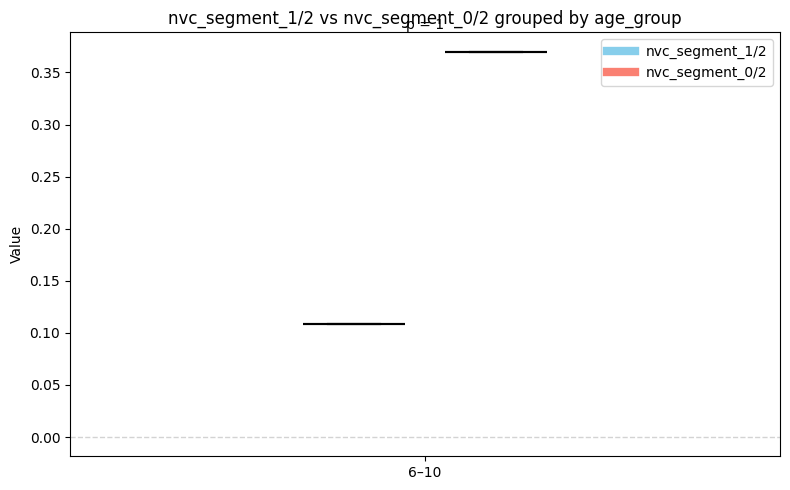

In [ ]:
from scipy.stats import mannwhitneyu

def plot_two_column_grouped_boxplot(
    df,
    col1,
    col2,
    group_by,
    params=None,
):
    """
    Plot grouped boxplots comparing two numerical columns (col1 vs col2)
    for each category in `group_by`, with Mann–Whitney U p-values.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns [col1, col2, group_by].
    col1 : str
        First numeric column for comparison.
    col2 : str
        Second numeric column for comparison.
    group_by : str
        Column to group along the x-axis.
    params : dict
        Optional style overrides.
    """

    # ---- defaults ----
    defaults = {
        "colors": ["skyblue", "salmon"],
        "figsize": (8, 5),
        "title": f"{col1} vs {col2} grouped by {group_by}",
        "ylabel": "Value",
        "group_gap": 1.5,
        "pair_gap": 0.25,
        "box_width": 0.18,
        "box_linewidth": 1.5,
        "legend_labels": [col1, col2],
        "pval_fontsize": 10,
        "pval_y_offset": 0.05,
        "y0_line": True,
    }
    if params is not None:
        defaults.update(params)
    p = defaults

    # ---- validation ----
    for c in [col1, col2, group_by]:
        if c not in df.columns:
            raise ValueError(f"Column '{c}' missing from dataframe")

    # ---- extract and group data ----
    unique_groups = sorted(df[group_by].dropna().unique())
    groups = []
    for g in unique_groups:
        sub = df[df[group_by] == g]
        arr1 = sub[col1].dropna().values
        arr2 = sub[col2].dropna().values
        groups.append((arr1, arr2))

    # ---- prepare plot ----
    fig, ax = plt.subplots(figsize=p["figsize"])
    positions, box_data, color_list, widths = [], [], [], []
    pos = 1

    for g in groups:
        for i, arr in enumerate(g):
            box_data.append(arr)
            positions.append(pos + i * p["pair_gap"])
            color_list.append(p["colors"][i])
            widths.append(p["box_width"])
        pos += len(g) + p["group_gap"]

    # ---- draw boxplots ----
    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=widths,
        patch_artist=True,
        medianprops=dict(color="black", linewidth=p["box_linewidth"]),
        boxprops=dict(linewidth=p["box_linewidth"]),
        whiskerprops=dict(linewidth=p["box_linewidth"]),
        capprops=dict(linewidth=p["box_linewidth"]),
    )

    for patch, c in zip(bp["boxes"], color_list):
        patch.set_facecolor(c)
        patch.set_edgecolor("black")

    if p["y0_line"]:
        ax.axhline(0, color="lightgrey", linestyle="--", linewidth=1)

    # ---- xticks ----
    xtick_positions = []
    pos_idx = 0
    for g in groups:
        xtick_positions.append(np.mean(positions[pos_idx:pos_idx+2]))
        pos_idx += 2

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(unique_groups)
    ax.set_xlim(min(positions) - 0.5, max(positions) + 0.5)
    ax.set_ylabel(p["ylabel"])
    ax.set_title(p["title"])

    # ---- p-values (Mann–Whitney U) ----
    for i, g in enumerate(groups):
        a1, a2 = g
        if len(a1) > 0 and len(a2) > 0:
            _, pval = mannwhitneyu(a1, a2, alternative="two-sided")
        else:
            pval = np.nan

        xpos = xtick_positions[i]
        ymax = np.nanmax([np.nanmax(a1) if len(a1) else 0,
                          np.nanmax(a2) if len(a2) else 0])
        y_text = ymax + abs(ymax) * p["pval_y_offset"]

        label = f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a"
        ax.text(xpos, y_text, label,
                ha="center", va="bottom",
                fontsize=p["pval_fontsize"])

    # ---- legend ----
    handles = [
        plt.Line2D([0], [0], color=c, lw=6, label=lbl)
        for c, lbl in zip(p["colors"], p["legend_labels"])
    ]
    ax.legend(handles=handles)

    plt.tight_layout()
    return fig


######## GROUPED BY AGE/SEX

whole_file = os.path.join(data_folder, f"nvc_whole_{file_id}_df.csv")
# y_axis = "nvc_se"



# params.update({"title": f"{y_axis} by sex", "ylabel": y_axis})
# fig = plot_age_sex_grouped_boxplot(pd.read_csv(whole_file), y_axis, pval_func=pval_func, params=params, group_by="sex")


# Define your custom binning
age_map = {
    6: "6–10",
    8: "6–10",
    10: "6–10",
    12: "12–16",
    14: "12–16",
    16: "12–16"
}

# Create a new column in the dataframe
df = pd.read_csv(whole_file)
df["age_group"] = df["age"].map(age_map)

# params.update({"title": f"{y_axis} by age", "ylabel": y_axis})
fig = plot_two_column_grouped_boxplot(df, "nvc_segment_1/2", "nvc_segment_0/2", group_by="age_group")

C:\Users\torte\AppData\Local\Temp\ipykernel_23836\571341243.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


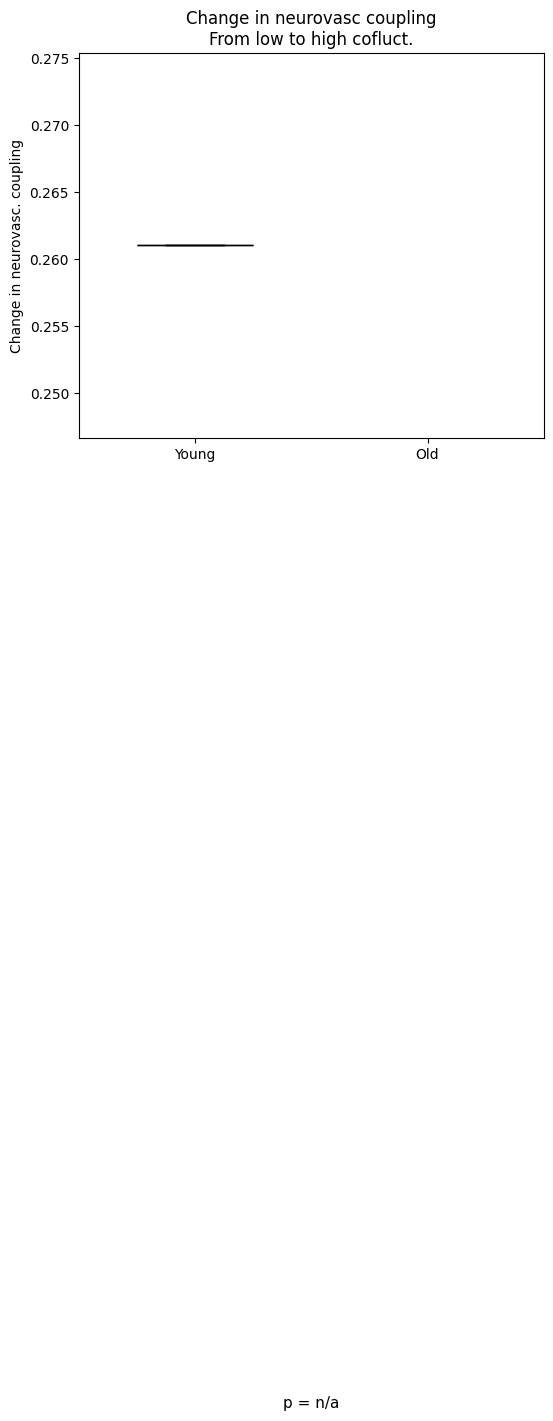

In [ ]:
def boxplot_two_vectors(
        
    vec1,
    vec2,
    xlabel1="A",
    xlabel2="B",
    ylabel="Value",
    title=None,
    color1="skyblue",
    color2="salmon",
    box_width=0.5,
):
    """
    Plot two vectors in side-by-side boxplots with a Mann–Whitney U p-value.

    Parameters
    ----------
    vec1, vec2 : array-like
        Numeric data vectors.
    xlabel1, xlabel2 : str
        X-axis tick labels.
    ylabel : str
        Y-axis label.
    title : str, optional
        Plot title.
    """

    v1 = np.asarray(vec1)
    v2 = np.asarray(vec2)

    # ---- Compute p-value ----
    if len(v1) > 0 and len(v2) > 0:
        _, pval = mannwhitneyu(v1, v2, alternative="two-sided")
    else:
        pval = np.nan

    # ---- Create figure ----
    fig, ax = plt.subplots(figsize=(6, 5))

    box_data = [v1, v2]
    positions = [1, 2]
    colors = [color1, color2]

    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=dict(color="black"),
    )

    # color the boxes
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)
        patch.set_edgecolor("black")

    # axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels([xlabel1, xlabel2])
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    # ---- place p-value ----
    ymax = np.nanmax([np.nanmax(v1) if len(v1) else 0,
                      np.nanmax(v2) if len(v2) else 0])
    y_text = ymax + 0.05 * abs(ymax)

    label = f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a"
    ax.text(1.5, y_text-0.1, label, ha="center", va="bottom", fontsize=11)

    plt.tight_layout()
    return fig, ax

whole_file = os.path.join(data_folder, f"nvc_whole_{file_id}_df.csv")
df = pd.read_csv(whole_file)

age_map = {
    6: "6-10",
    8: "6-10",
    10: "6-10",
    12: "12-16",
    14: "12-16",
    16: "12-16"
}

df["age_group"] = df["age"].map(age_map)
df["age_group"] = df["age_group"].astype(str).str.strip("'")
# print(df["age_group"].unique())

df["nvc_diff"] = df["nvc_segment_0/2"] - df["nvc_segment_1/2"]

# list columns (confirm name)
# print(df.columns.tolist())

# # examine unique values and counts (shows hidden characters with repr)
# vals = df["age_group"].dropna()
# print("dtype:", df["age_group"].dtype)
# print("unique (repr):", [repr(v) for v in vals.unique()])
# print(df["age_group"].value_counts(dropna=False).head(20))

# show sample rows that look like they should match
# print(df.loc[df["age_group"].astype(str).str.contains("6", na=False), ["age_group"]].head(20))

# print(df.loc[df["age_group"] == "6-10", "nvc_diff"].values)

fig, ax = boxplot_two_vectors(df.loc[df["age_group"] == "6-10", "nvc_diff"].values, df.loc[df["age_group"] == "12-16", "nvc_diff"].values, "Young", "Old", "Change in neurovasc. coupling", title="Change in neurovasc coupling\nFrom low to high cofluct.")
plt.show()



# Functional similarity

In [20]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(first segment) functional similarity by region",
    "ylabel": "funcsim_segment_0/2",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcsim_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcsim_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="funcsim_segment_0/2", params=params, pval_func=pval_func, null_filenames=None)
plt.show()


########################

for region in regions:
    for id in [file_id]: # [file_id, f"{version}_null_shuffle"]

        filename = os.path.join(data_folder, f"funcsim_region_{region}_{id}_df.csv")
        df = return_dataframe(filename)
        df["funcsim_gap"] = df["funcsim_segment_0/2"] - df["funcsim_segment_1/2"]
        save_dataframe(df, os.path.join(data_folder, f"funcsim_region_{region}_{id}_df.csv"))

params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "Functional similarity by region\ndifference between first and last segment",
    "ylabel": "funcsim_gap",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcsim_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcsim_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="funcsim_gap", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()

######## GROUPED BY AGE/SEX

whole_file = os.path.join(data_folder, f"funcsim_whole_{file_id}_df.csv")
y_axis = "funcsim_whole"

params.update({"title": f"{y_axis} by age", "ylabel": y_axis})
fig = plot_age_sex_grouped_boxplot(pd.read_csv(whole_file), y_axis, pval_func=pval_func, params=params, group_by="age")

params.update({"title": f"{y_axis} by sex", "ylabel": y_axis})
fig = plot_age_sex_grouped_boxplot(pd.read_csv(whole_file), y_axis, pval_func=pval_func, params=params, group_by="sex")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/torte/Downloads/df_v3/dataframes/old\\funcsim_region_Motor_left_v2_mvmt_df.csv'

C:\Users\torte\AppData\Local\Temp\ipykernel_4436\3305568264.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="GCaMP", y=column, data=df, palette=["lightblue", "salmon"])


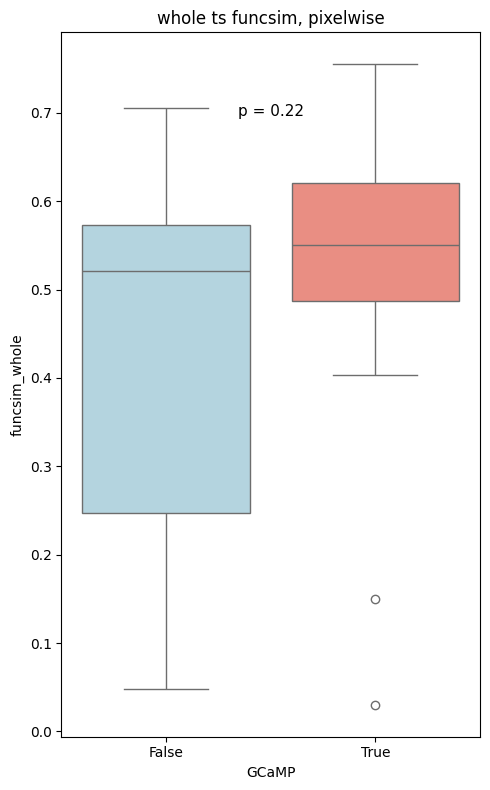

C:\Users\torte\AppData\Local\Temp\ipykernel_4436\3305568264.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="GCaMP", y=column, data=df, palette=["lightblue", "salmon"])


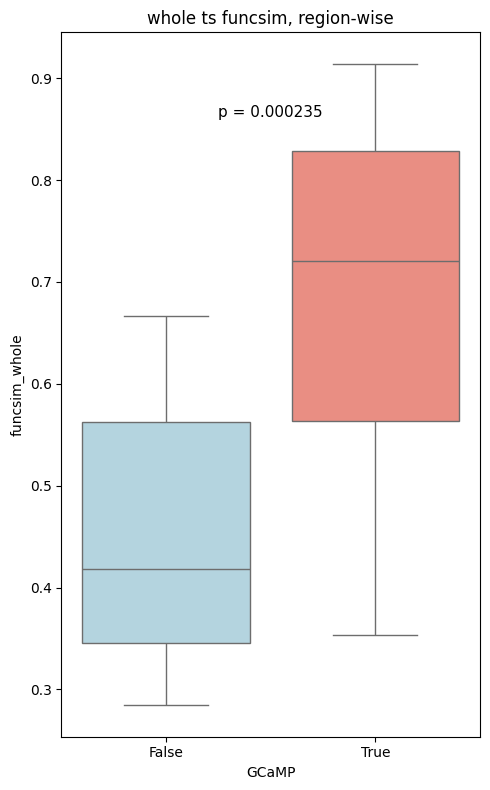

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

def plot_boxplot(df, column, test="mannwhitney", title=None):
    """
    Plot two boxplots (GCaMP=False, GCaMP=True) for the given column
    and compute a p-value between them.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns 'GCaMP' and the given `column`.
    column : str
        Column name to plot.
    test : str, optional
        Statistical test to use: 't-test' or 'mannwhitney' (default: 't-test').
    """
    if "GCaMP" not in df.columns:
        raise ValueError("'GCaMP' column missing from dataframe.")
    if column not in df.columns:
        raise ValueError(f"'{column}' column missing from dataframe.")

    data_false = df.loc[df["GCaMP"] == False, column].dropna()
    data_true = df.loc[df["GCaMP"] == True, column].dropna()

    # --- compute p-value ---
    if len(data_false) == 0 or len(data_true) == 0:
        pval = np.nan
    else:
        if test == "t-test":
            _, pval = ttest_ind(data_false, data_true, equal_var=False)
        elif test == "mannwhitney":
            _, pval = mannwhitneyu(data_false, data_true, alternative="two-sided")
        else:
            raise ValueError("test must be 't-test' or 'mannwhitney'")

    # --- plot ---
    plt.figure(figsize=(5, 8))
    ax = sns.boxplot(x="GCaMP", y=column, data=df, palette=["lightblue", "salmon"])
    plt.title(title)

    # --- p-value annotation ---
    y_max = max(df[column].dropna())
    y_text = y_max + abs(y_max) * 0.05 - 0.1
    label = f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a"
    ax.text(0.5, y_text, label, ha="center", va="bottom", fontsize=11)

    plt.tight_layout()
    plt.show()


plot_boxplot(return_dataframe(os.path.join(data_folder, f"funcsim_whole_{file_id}_df.csv")), "funcsim_whole", title="whole ts funcsim, pixelwise")

plot_boxplot(return_dataframe(os.path.join(data_folder, f"funcsim_registered_{file_id}_df.csv")), "funcsim_whole", title="whole ts funcsim, region-wise")

# Functional representativity

In [21]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(first segment) GCaMP functional representativity by region",
    "ylabel": "GCaMP_funcrep_segment_0/2",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcrep_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcrep_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="GCaMP_funcrep_segment_0/2", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()

#####################

params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(first segment) dHbT functional representativity by region",
    "ylabel": "dHbT_funcrep_segment_0/2",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcrep_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcrep_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="dHbT_funcrep_segment_0/2", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/torte/Downloads/df_v3/dataframes/old\\funcrep_region_Motor_left_v2_mvmt_df.csv'

# Modularity

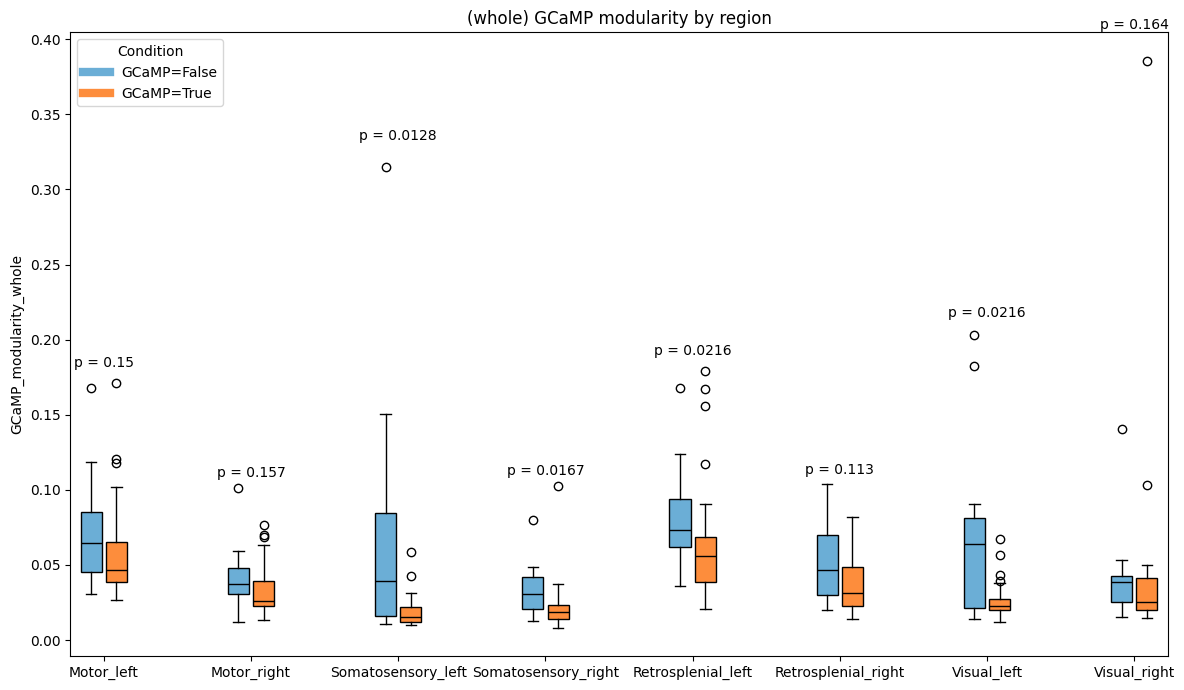

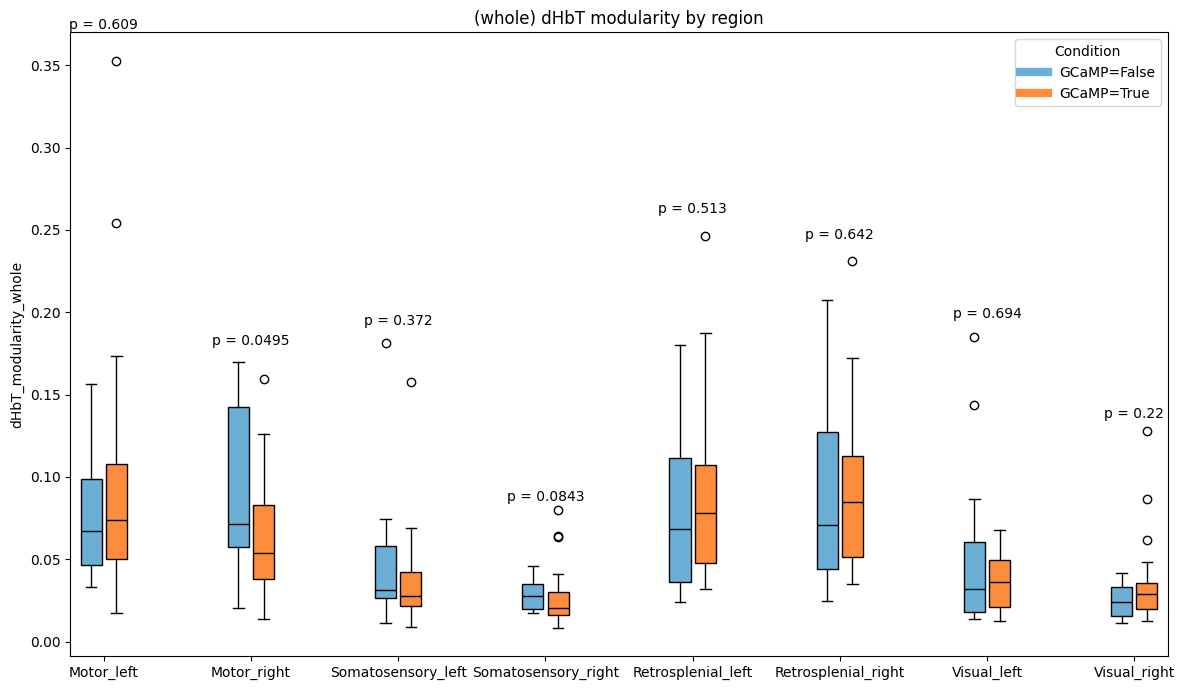

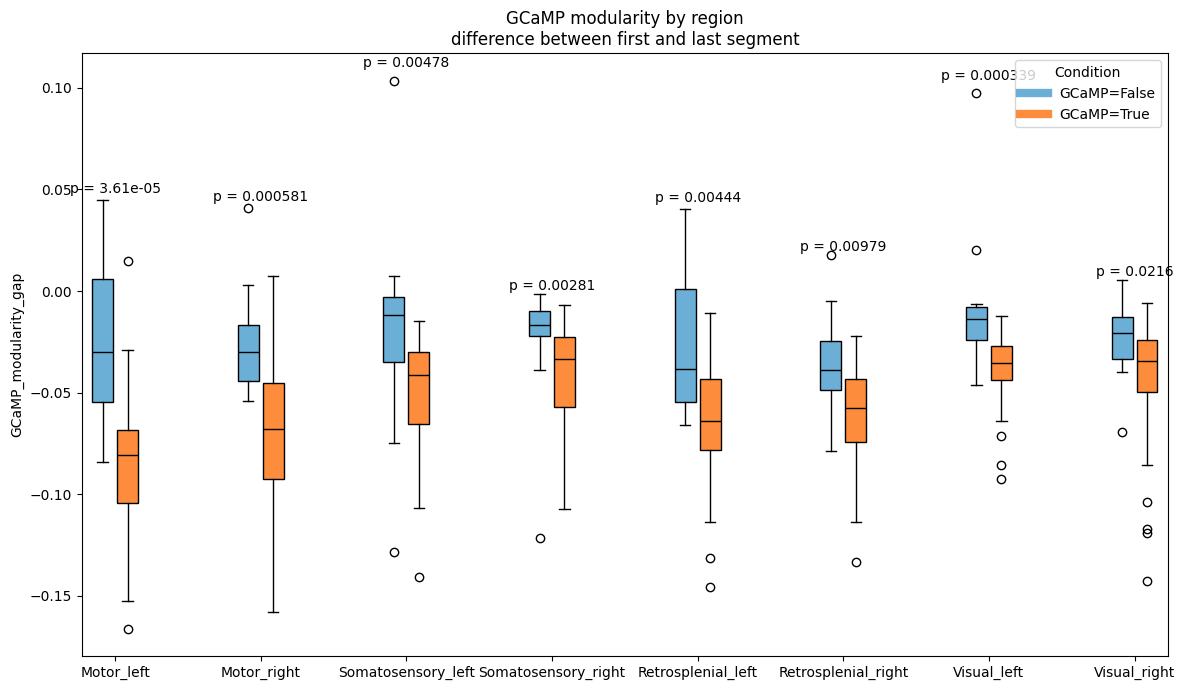

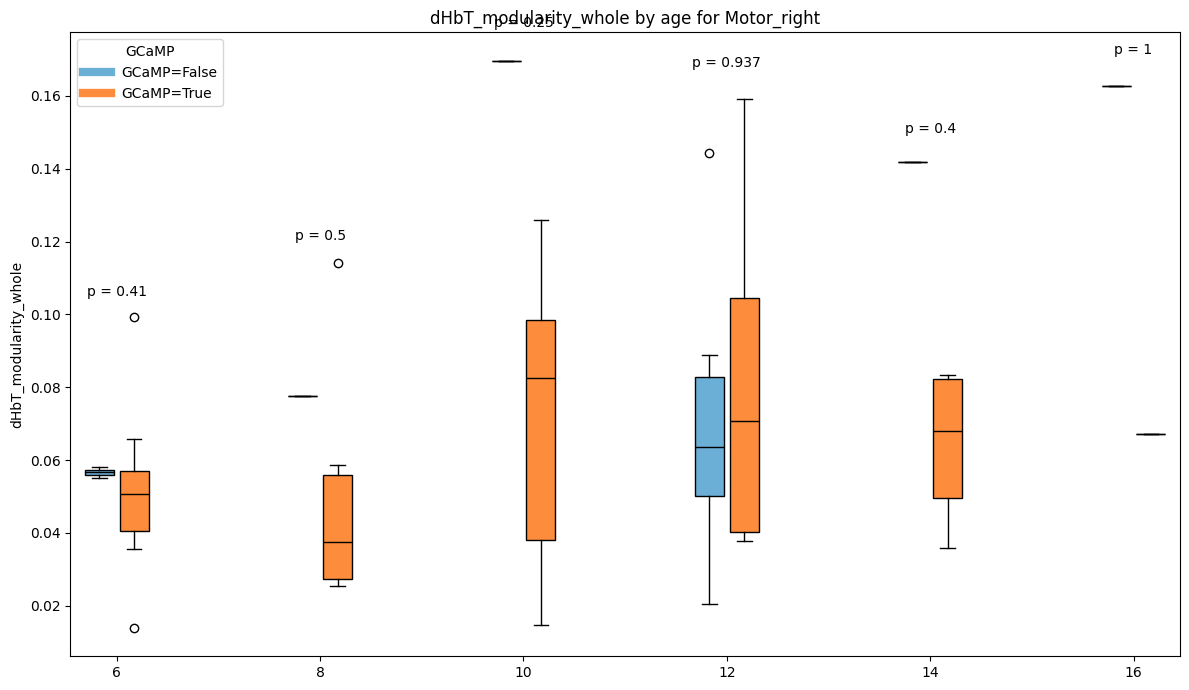

In [ ]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) GCaMP modularity by region",
    "ylabel": "GCaMP_modularity_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"modularity_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"modularity_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="GCaMP_modularity_whole", params=params, pval_func=pval_func, null_filenames=None)
plt.show()



#####################


params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) dHbT modularity by region",
    "ylabel": "dHbT_modularity_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"modularity_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"modularity_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="dHbT_modularity_whole", params=params, pval_func=pval_func, null_filenames=None)
plt.show()


##############################


for region in regions:
    for id in [file_id]: # [file_id, f"{version}_null_shuffle"]

        filename = os.path.join(data_folder, f"modularity_region_{region}_{id}_df.csv")
        df = return_dataframe(filename)
        df["GCaMP_modularity_gap"] = df["GCaMP_modularity_segment_0/2"] - df["GCaMP_modularity_segment_1/2"]
        save_dataframe(df, os.path.join(data_folder, f"modularity_region_{region}_{id}_df.csv"))


params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "GCaMP modularity by region\ndifference between first and last segment",
    "ylabel": "GCaMP_modularity_gap",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"modularity_region_{region}_{file_id}_df.csv") for region in regions]
# null_filenames = [[os.path.join(data_folder, f"modularity_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="GCaMP_modularity_gap", params=params, pval_func=pval_func, null_filenames=None)
plt.show()

######## GROUPED BY AGE/SEX

region = "Motor_right"

file = os.path.join(data_folder, f"modularity_region_{region}_{file_id}_df.csv")
y_axis = "dHbT_modularity_whole"

params.update({"title": f"{y_axis} by age for {region}", "ylabel": y_axis})
fig = plot_age_sex_grouped_boxplot(pd.read_csv(file), y_axis, pval_func=pval_func, params=params, group_by="age")

C:\Users\torte\AppData\Local\Temp\ipykernel_4436\3305568264.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="GCaMP", y=column, data=df, palette=["lightblue", "salmon"])


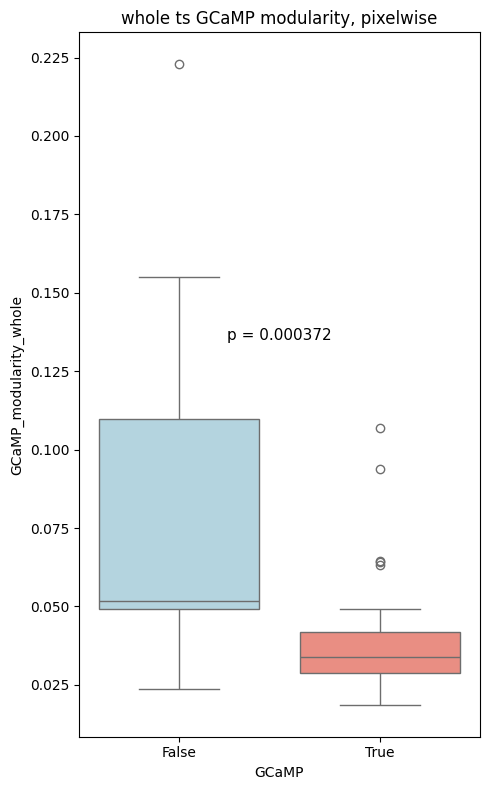

C:\Users\torte\AppData\Local\Temp\ipykernel_4436\3305568264.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="GCaMP", y=column, data=df, palette=["lightblue", "salmon"])


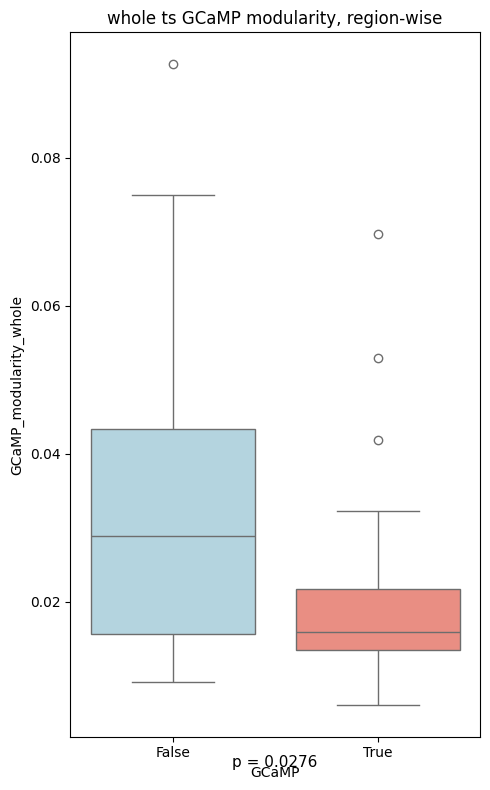

C:\Users\torte\AppData\Local\Temp\ipykernel_4436\3305568264.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="GCaMP", y=column, data=df, palette=["lightblue", "salmon"])


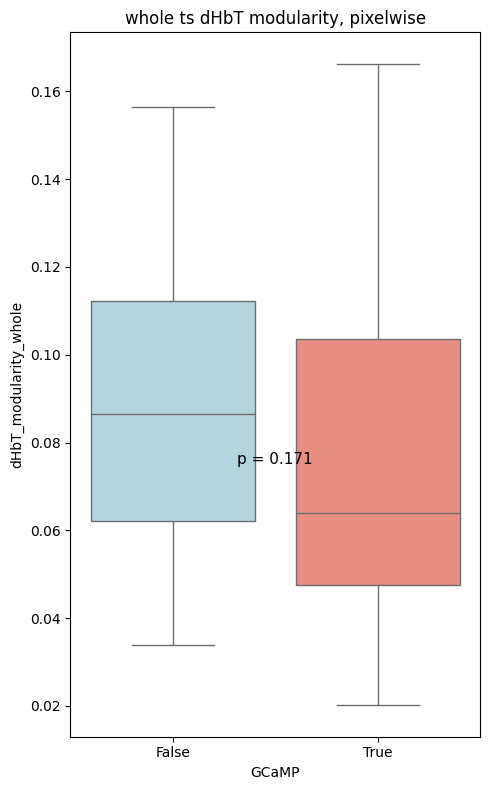

C:\Users\torte\AppData\Local\Temp\ipykernel_4436\3305568264.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="GCaMP", y=column, data=df, palette=["lightblue", "salmon"])


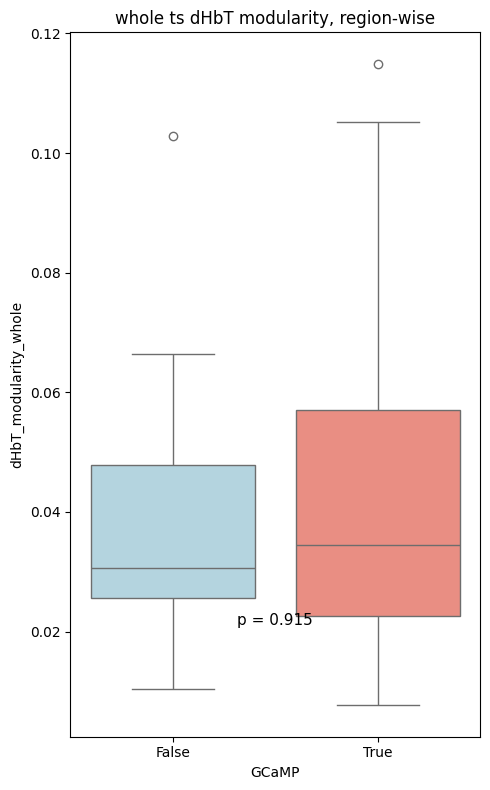

In [ ]:
plot_boxplot(return_dataframe(os.path.join(data_folder, f"modularity_whole_{file_id}_df.csv")), "GCaMP_modularity_whole", title="whole ts GCaMP modularity, pixelwise")
plot_boxplot(return_dataframe(os.path.join(data_folder, f"modularity_registered_{file_id}_df.csv")), "GCaMP_modularity_whole", title="whole ts GCaMP modularity, region-wise")

plot_boxplot(return_dataframe(os.path.join(data_folder, f"modularity_whole_{file_id}_df.csv")), "dHbT_modularity_whole", title="whole ts dHbT modularity, pixelwise")
plot_boxplot(return_dataframe(os.path.join(data_folder, f"modularity_registered_{file_id}_df.csv")), "dHbT_modularity_whole", title="whole ts dHbT modularity, region-wise")

# TESTS

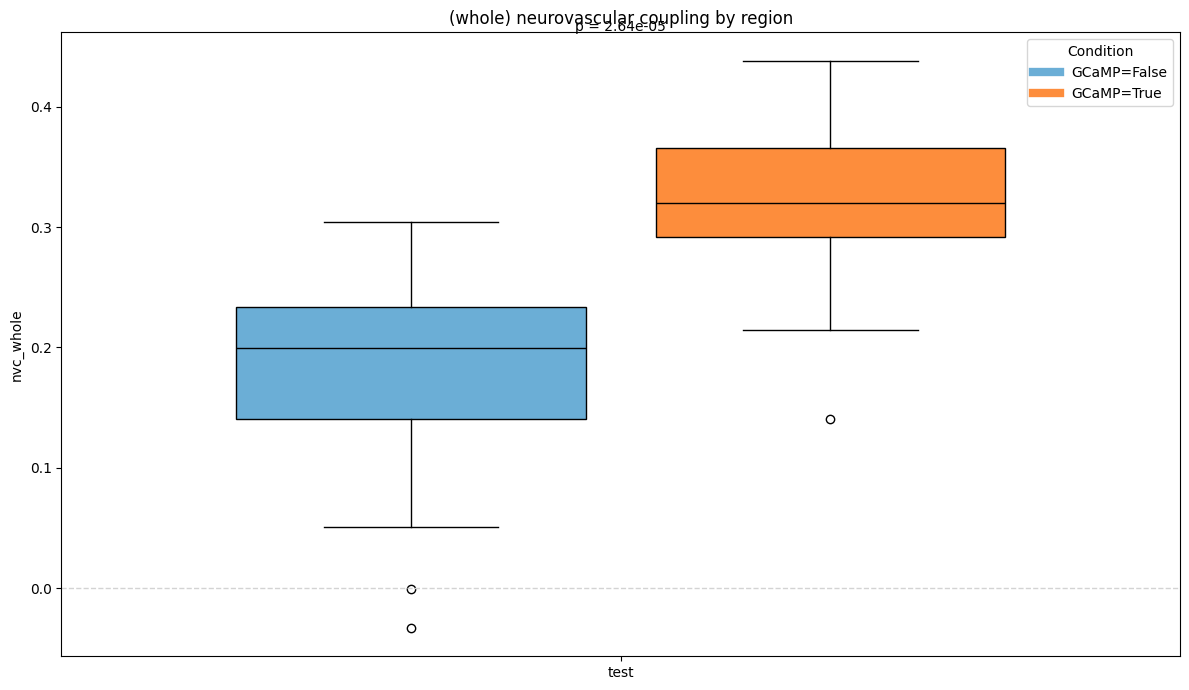

In [ ]:
def plot_csv_groups(filenames, regions, column, null_filenames=None, params=None, pval_func=None):
    """
    Create grouped boxplots from CSV files, optionally including null model data.

    Parameters
    ----------
    filenames : list[str]
        List of main CSV filenames, one per group. Each must contain 'GCaMP' column.
    regions : list[str]
        Labels for each group on the x-axis.
    column : str
        Column name to extract from each CSV for plotting.
    null_filenames : list[list[str]] or None
        Nested list of null model filenames corresponding to each group.
        Example: [["null1a.csv", "null1b.csv"], ["null2a.csv"], []]
    params : dict or None
        Optional parameters for plot appearance.
    pval_func : callable or None
        Function for computing p-values between selected datasets.
    """
    groups = []

    for i, fname in enumerate(filenames):
        df = pd.read_csv(fname)
        if "GCaMP" not in df.columns:
            raise ValueError(f"'GCaMP' column missing in {fname}")
        if column not in df.columns:
            raise ValueError(f"'{column}' column missing in {fname}")

        # Main data: split into False and True groups
        data_false = df.loc[df["GCaMP"] == False, column].dropna().values
        data_true = df.loc[df["GCaMP"] == True, column].dropna().values

        group = [data_false, data_true]

        # ---- Add null models if provided ----
        if null_filenames is not None and i < len(null_filenames):
            for null_file in null_filenames[i]:
                ndf = pd.read_csv(null_file)
                if "GCaMP" not in ndf.columns:
                    raise ValueError(f"'GCaMP' column missing in null model file {null_file}")
                if column not in ndf.columns:
                    raise ValueError(f"'{column}' column missing in null model file {null_file}")
                
                # Only use GCaMP=True rows for null models
                null_data = ndf.loc[ndf["GCaMP"] == True, column].dropna().values
                group.append(null_data)

        groups.append(tuple(group))

    fig = grouped_boxplot(groups, regions, params, pval_func=pval_func)
    return fig



params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) neurovascular coupling by region",
    "ylabel": "nvc_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6
}

files = [os.path.join(data_folder, f"nvc_whole_{file_id}_df.csv")]
# null_filenames = [[os.path.join(data_folder, f"nvc_region_{region}_{version}_null_shuffle_df.csv")] for region in regions]
null_filenames = None

fig = plot_csv_groups(files, regions=["test"], column="nvc_whole", params=params, pval_func=pval_func, null_filenames=None)
plt.show()